In [1]:
import json
import sqlite3
from pathlib import Path
from typing import TypedDict, List, Dict, Any
from datetime import datetime
from langgraph.graph import StateGraph, START
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

In [2]:
class AgentState(TypedDict):
    date: str
    is_valid: bool
    conn: sqlite3.Connection
    upcoming: List[Dict[str, Any]]
    formatted: str
    llm_message: str

# Memoria Semántica

In [3]:

SEMANTIC_MEMORY = {
    "IVA": "Impuesto al Valor Agregado, obligación mensual.",
    "ISLR": "Impuesto sobre la Renta, declaración anual o provisional.",
    "Retención": "Retención de impuestos a terceros, según normativa vigente.",
    "Multa": "Penalización por incumplimiento de obligaciones anteriores.",
    "Formulario": "Presentación administrativa requerida por la autoridad fiscal."
}

# Nodos

Aqui integramos los nodos con las diferentes memorias indicadas en la tarea.

In [4]:
def get_date_node(state: AgentState) -> AgentState:
    state["date"] = state["date"].strip()
    return state

def validate_date_node(state: AgentState) -> AgentState:
    try:
        datetime.strptime(state["date"], "%Y-%m-%d")
        state["is_valid"] = True
    except ValueError:
        state["is_valid"] = False
    return state

def setup_db_node(state: AgentState) -> AgentState:
    conn = sqlite3.connect(":memory:")
    cur = conn.cursor()

    # Tabla principal
    cur.execute("""
    CREATE TABLE obligations(
      id               INTEGER PRIMARY KEY,
      name             TEXT,
      description      TEXT,
      due_date         TEXT,
      type             TEXT,
      amount_value     REAL,
      amount_currency  TEXT,
      status           TEXT,
      assigned_to_id   INTEGER,
      assigned_to_name TEXT,
      assigned_to_email TEXT,
      period_start     TEXT,
      period_end       TEXT,
      history_json     TEXT,
      reminders_json   TEXT,
      attachments_json TEXT,
      notes_json       TEXT
    )""")

    # 🧠 Tabla para memoria episódica
    cur.execute("""
    CREATE TABLE execution_log (
        run_id INTEGER PRIMARY KEY AUTOINCREMENT,
        input_date TEXT,
        num_obligations INTEGER,
        timestamp TEXT
    )
    """)

    path = Path(r"C:\Users\XXXX\Documents\MaestriaIA\AgentesLLMv1\obligations.json")
    data = json.loads(path.read_text(encoding="utf-8"))
    obligations = data.get("obligations", [])
    rows = []
    for o in obligations:
        rows.append((
            o.get("id"),
            o.get("name"),
            o.get("description"),
            o.get("due_date"),
            o.get("type"),
            o.get("amount", {}).get("value"),
            o.get("amount", {}).get("currency"),
            o.get("status"),
            o.get("assigned_to", {}).get("user_id"),
            o.get("assigned_to", {}).get("name"),
            o.get("assigned_to", {}).get("email"),
            o.get("period", {}).get("start"),
            o.get("period", {}).get("end"),
            json.dumps(o.get("history", [])),
            json.dumps(o.get("reminders", {})),
            json.dumps(o.get("attachments", [])),
            json.dumps(o.get("notes", []))
        ))
    cur.executemany("INSERT INTO obligations VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", rows)
    conn.commit()
    state["conn"] = conn
    return state

def query_db_node(state: AgentState) -> AgentState:
    if not state["is_valid"]:
        return state
    cur = state["conn"].cursor()
    cur.execute("""
      SELECT * FROM obligations
       WHERE due_date >= ?
       ORDER BY due_date
    """, (state["date"],))
    cols = [col[0] for col in cur.description]
    results = [dict(zip(cols, row)) for row in cur.fetchall()]
    state["upcoming"] = results

    # 🧠 Registrar memoria episódica
    cur.execute("""
      INSERT INTO execution_log (input_date, num_obligations, timestamp)
      VALUES (?, ?, ?)
    """, (state["date"], len(results), datetime.now().isoformat()))
    state["conn"].commit()
    return state

def format_results_node(state: AgentState) -> AgentState:
    if not state["is_valid"]:
        state["formatted"] = "Error: formato de fecha inválido."
    elif not state.get("upcoming"):
        state["formatted"] = f"Para {state['date']}, no hay obligaciones próximas."
    else:
        lines = []
        for o in state["upcoming"]:
            parts = [f"[{o['type']}] {o['name']}"]
            # 🧠 Agregar significado desde la memoria semántica
            if o["type"] in SEMANTIC_MEMORY:
                parts.append(f"({SEMANTIC_MEMORY[o['type']]})")
            if o.get("amount_value") is not None:
                parts.append(f"{o['amount_value']} {o['amount_currency']}")
            if o.get("period_start"):
                parts.append(f"Periodo {o['period_start']}→{o['period_end']}")
            parts.append(f"Estado: {o['status']}")
            parts.append(f"Responsable: {o['assigned_to_name']}")
            parts.append(f"Vence: {o['due_date']}")
            notes = json.loads(o.get("notes_json", "[]"))
            if notes:
                parts.append(f"Notas: {'; '.join(notes)}")
            lines.append("- " + ", ".join(parts))
        header = f"📋 Obligaciones a partir de {state['date']}:\n"
        state["formatted"] = header + "\n".join(lines)
    return state

def final_report_node(state: AgentState) -> AgentState:
    state["conn"].close()
    return state

def llm_generate_communications(state: AgentState) -> AgentState:
    if not state["upcoming"]:
        state["llm_message"] = "No hay comunicaciones necesarias."
        return state

    resumen = []
    for o in state["upcoming"]:
        resumen.append(
            f"- {o['name']} ({o['type']}), vence el {o['due_date']}, asignado a {o['assigned_to_name']}."
        )
    
    prompt = f"""
Eres un asistente corporativo de cumplimiento fiscal. Redacta un correo profesional para notificar al responsable de las siguientes obligaciones fiscales que vencen pronto. Usa un lenguaje claro, formal y preciso. No agregues encabezado ni firma, solo el cuerpo del mensaje.

Obligaciones:
{chr(10).join(resumen)}
"""

    llm = ChatOpenAI(model="gpt-4", temperature=0.4)
    response = llm.invoke([HumanMessage(content=prompt)])
    state["llm_message"] = response.content.strip()
    return state

# Grafos

In [5]:
graph = StateGraph(AgentState)
graph.add_node("get_date",       get_date_node)
graph.add_node("validate_date",  validate_date_node)
graph.add_node("setup_db",       setup_db_node)
graph.add_node("query_db",       query_db_node)
graph.add_node("format_results", format_results_node)
graph.add_node("final_report",   final_report_node)
graph.add_node("llm_generate",   llm_generate_communications)

graph.add_edge(START,            "get_date")
graph.add_edge("get_date",       "validate_date")
graph.add_edge("validate_date",  "setup_db")
graph.add_edge("setup_db",       "query_db")
graph.add_edge("query_db",       "format_results")
graph.add_edge("format_results", "final_report")
graph.add_edge("final_report",   "llm_generate")

app = graph.compile()

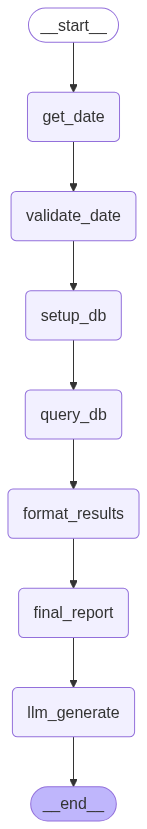

```mermaid
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	get_date(get_date)
	validate_date(validate_date)
	setup_db(setup_db)
	query_db(query_db)
	format_results(format_results)
	final_report(final_report)
	llm_generate(llm_generate)
	__end__([<p>__end__</p>]):::last
	__start__ --> get_date;
	final_report --> llm_generate;
	format_results --> final_report;
	get_date --> validate_date;
	query_db --> format_results;
	setup_db --> query_db;
	validate_date --> setup_db;
	llm_generate --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc

```

In [9]:
from IPython.display import display, Markdown
display(Image(app.get_graph().draw_mermaid_png()))
mermaid_code = app.get_graph().draw_mermaid()
display(Markdown(f"```mermaid\n{mermaid_code}\n```"))

In [7]:
if __name__ == "__main__":
    initial: AgentState = {
        "date":       "2025-08-30",
        "is_valid":   False,
        "conn":       None,
        "upcoming":   [],
        "formatted":  "",
        "llm_message": ""  
    }
    result = app.invoke(initial)
    print(result["formatted"])
    print("\n📧 Comunicación sugerida:\n")
    print(result["llm_message"])

📋 Obligaciones a partir de 2025-08-30:
- [Nómina] Liquidación sueldos, 23000.0 USD, Estado: Completado, Responsable: Carlos Gómez, Vence: 2025-08-31
- [Impuesto] Pago Renta, 7800.5 USD, Estado: Pendiente, Responsable: Ana Castillo, Vence: 2025-09-15, Notas: Requiere validación manual de deducciones; Confirmar datos con el departamento financiero

📧 Comunicación sugerida:

Estimados Carlos Gómez y Ana Castillo,

Espero que este mensaje les encuentre bien. Me dirijo a ustedes en relación a las obligaciones fiscales que han sido asignadas a cada uno y que están próximas a vencer.

Para Carlos Gómez, la fecha límite para la liquidación de sueldos (Nómina) es el 31 de agosto de 2025. Por favor, asegúrese de tener todos los cálculos y documentos necesarios listos y presentados antes de esa fecha para evitar cualquier posible penalización o multa.

Para Ana Castillo, le recordamos que el pago de la Renta (Impuesto) debe realizarse antes del 15 de septiembre de 2025. Por favor, asegúrese de qu